In [ ]:
pip install cma


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 7.5 MB/s eta 0:00:00


/tmp/ipython-input-1-2574154409.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


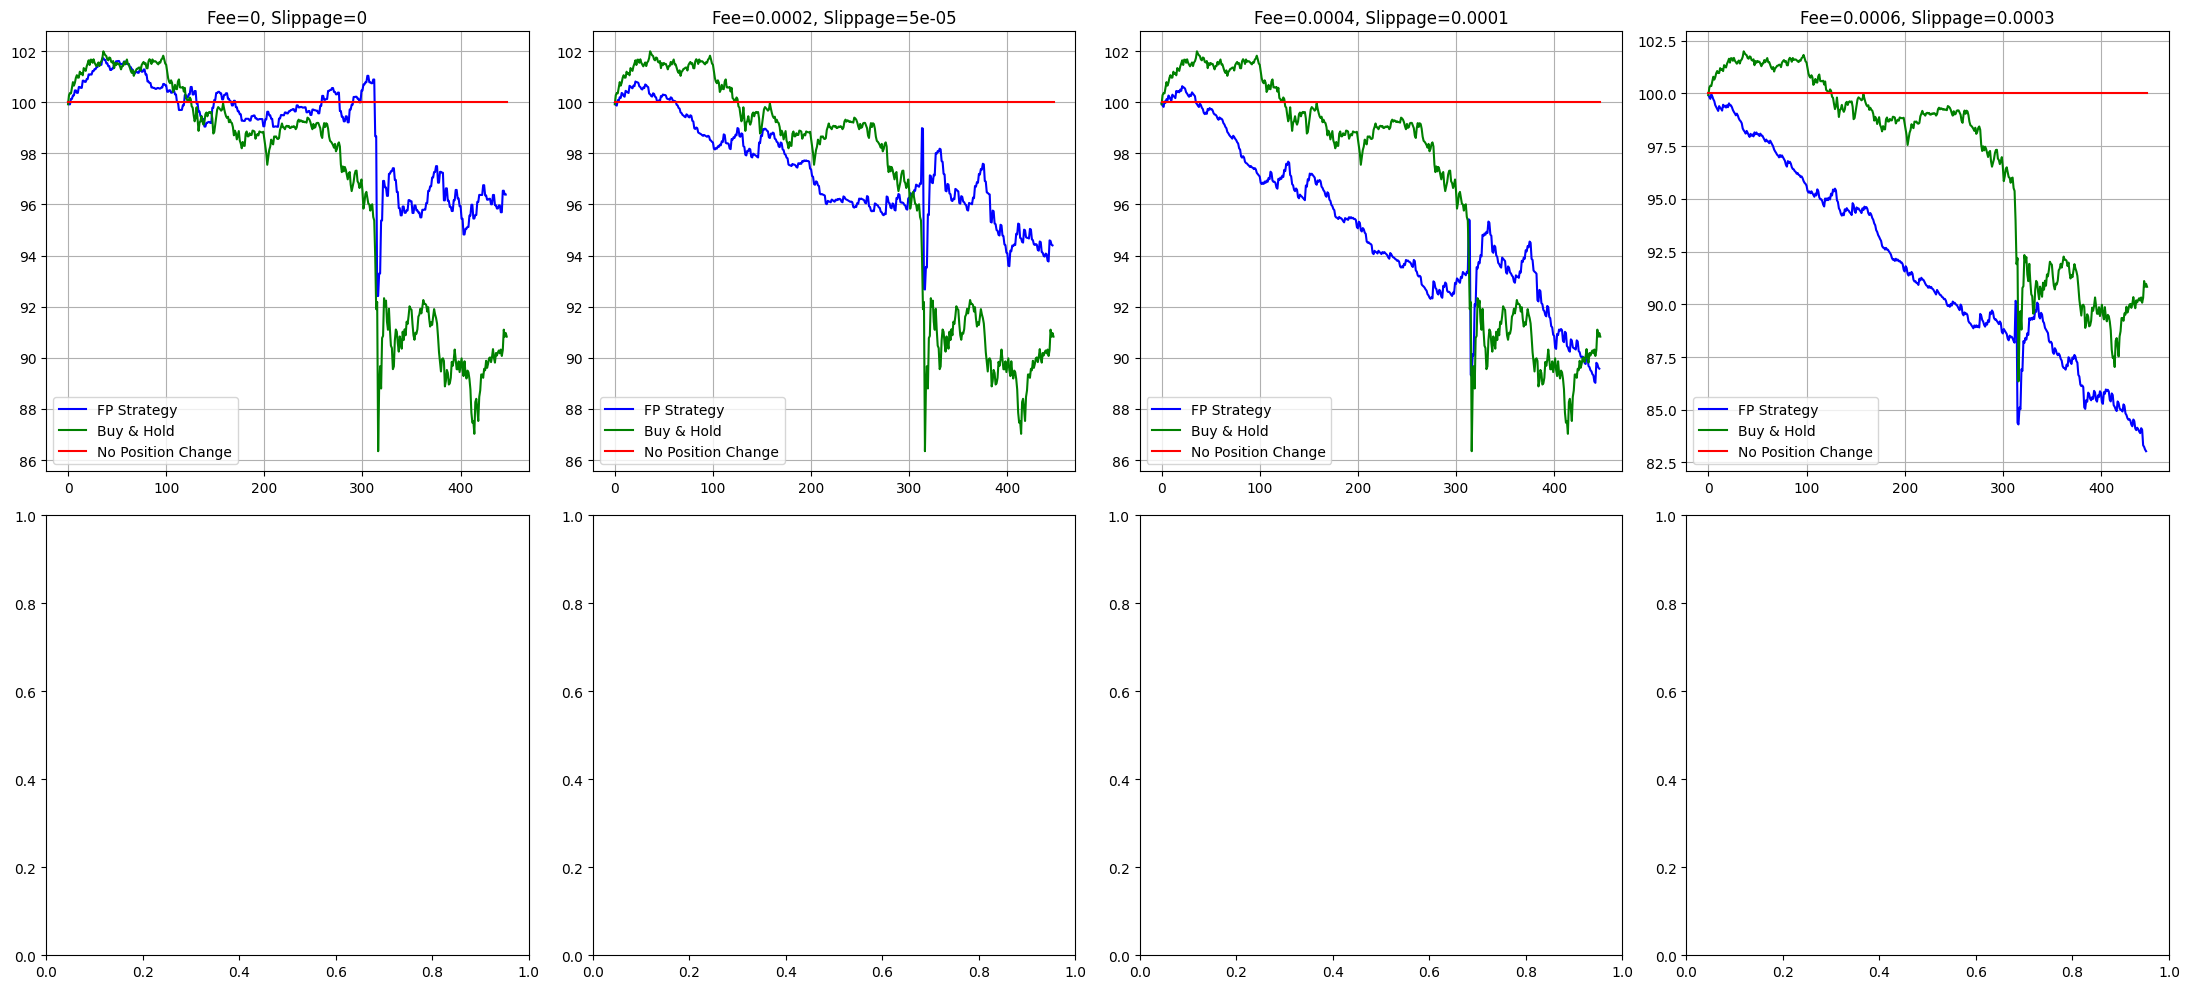


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            96.39          -3.61           90.83                  -9.17    100.0             0.0
0.0002   0.00005            94.40          -5.60           90.83                  -9.17    100.0             0.0
0.0004   0.00010            89.57         -10.43           90.83                  -9.17    100.0             0.0
0.0006   0.00030            83.03         -16.97           90.83                  -9.17    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

# Load and preprocess data
df = pd.read_csv("BTC_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.tanh(signal / threshold)
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    costs[~trade_mask] = 0
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = np.abs(first_position) * (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-5-3285940326.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


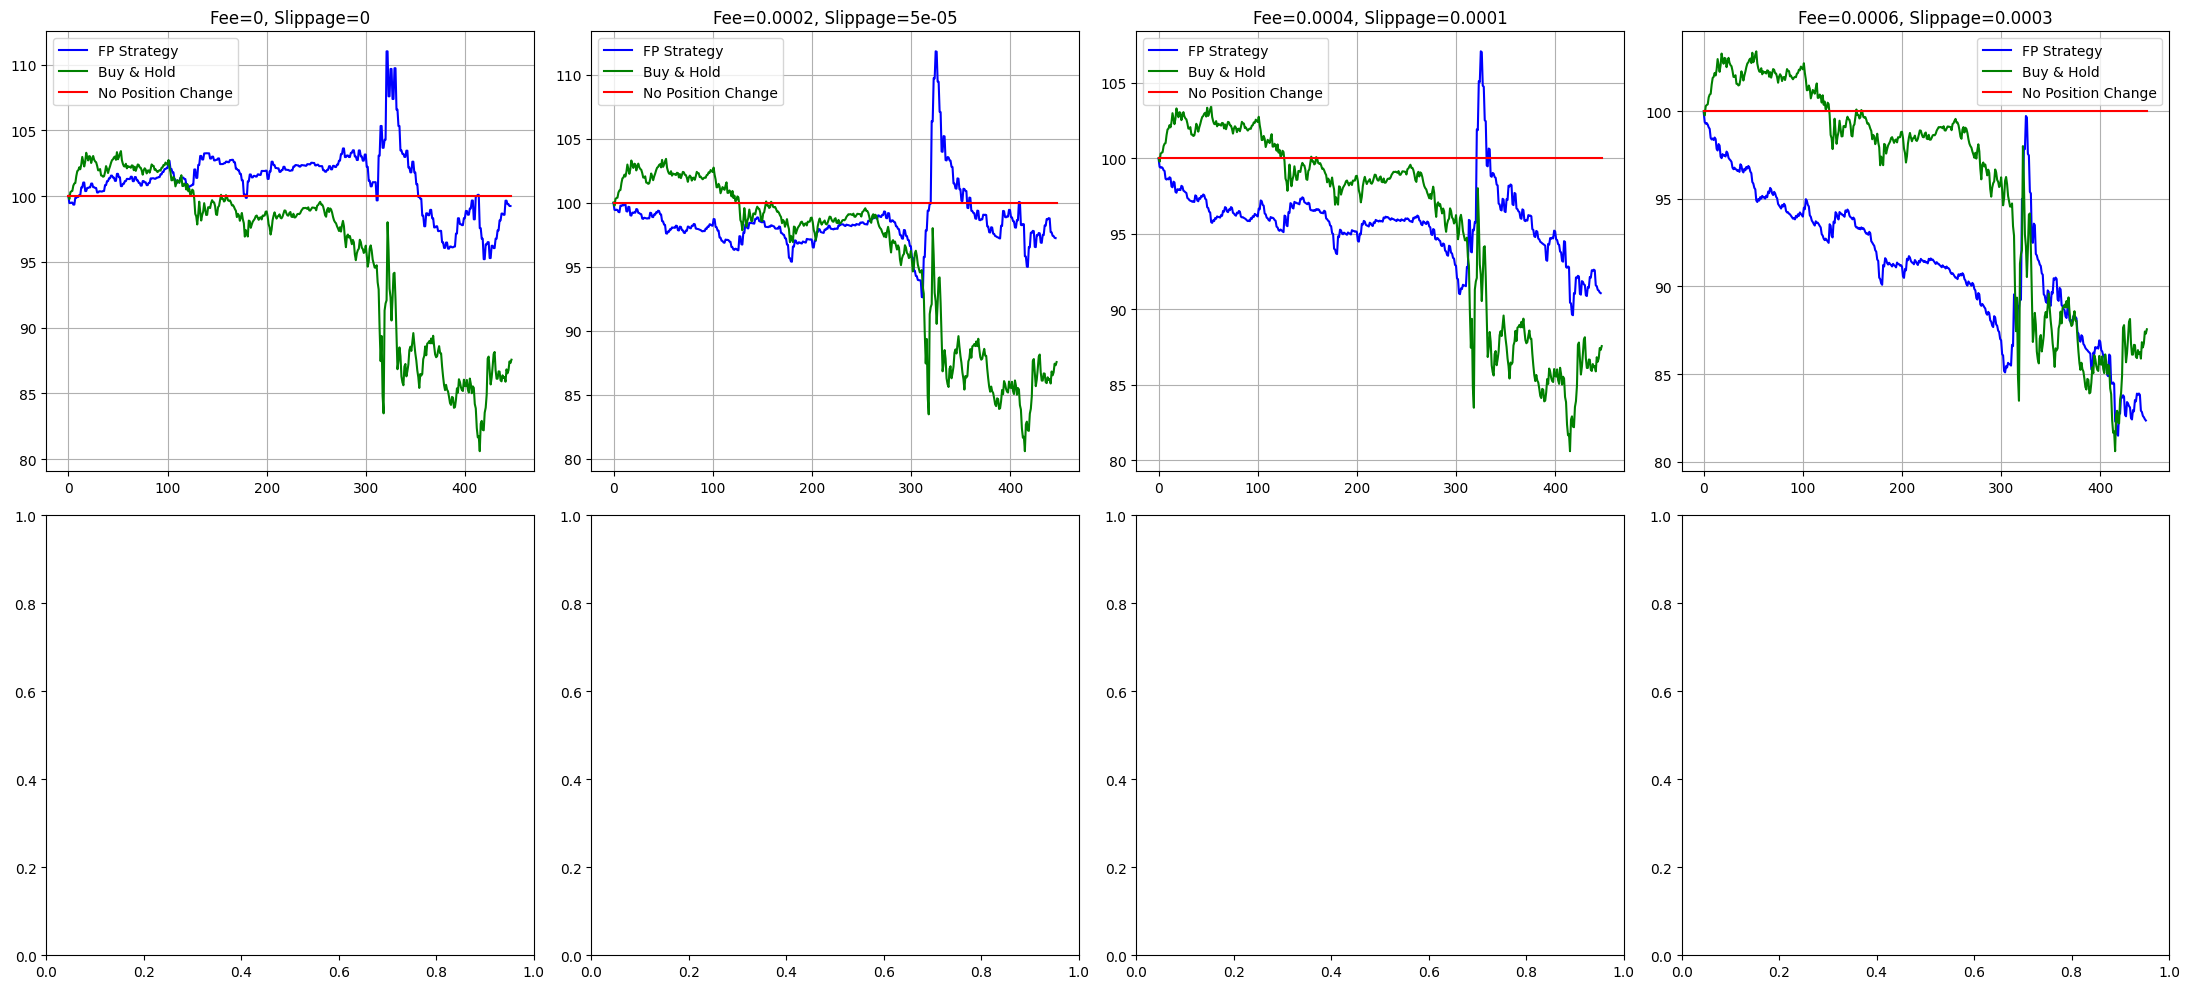


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            99.25          -0.75           87.56                 -12.44    100.0             0.0
0.0002   0.00005            97.24          -2.76           87.56                 -12.44    100.0             0.0
0.0004   0.00010            91.06          -8.94           87.56                 -12.44    100.0             0.0
0.0006   0.00030            82.35         -17.65           87.56                 -12.44    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

# Load and preprocess data
df = pd.read_csv("ADA_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.tanh(signal / threshold)
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    costs[~trade_mask] = 0
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = np.abs(first_position) * (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-2-4090820205.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


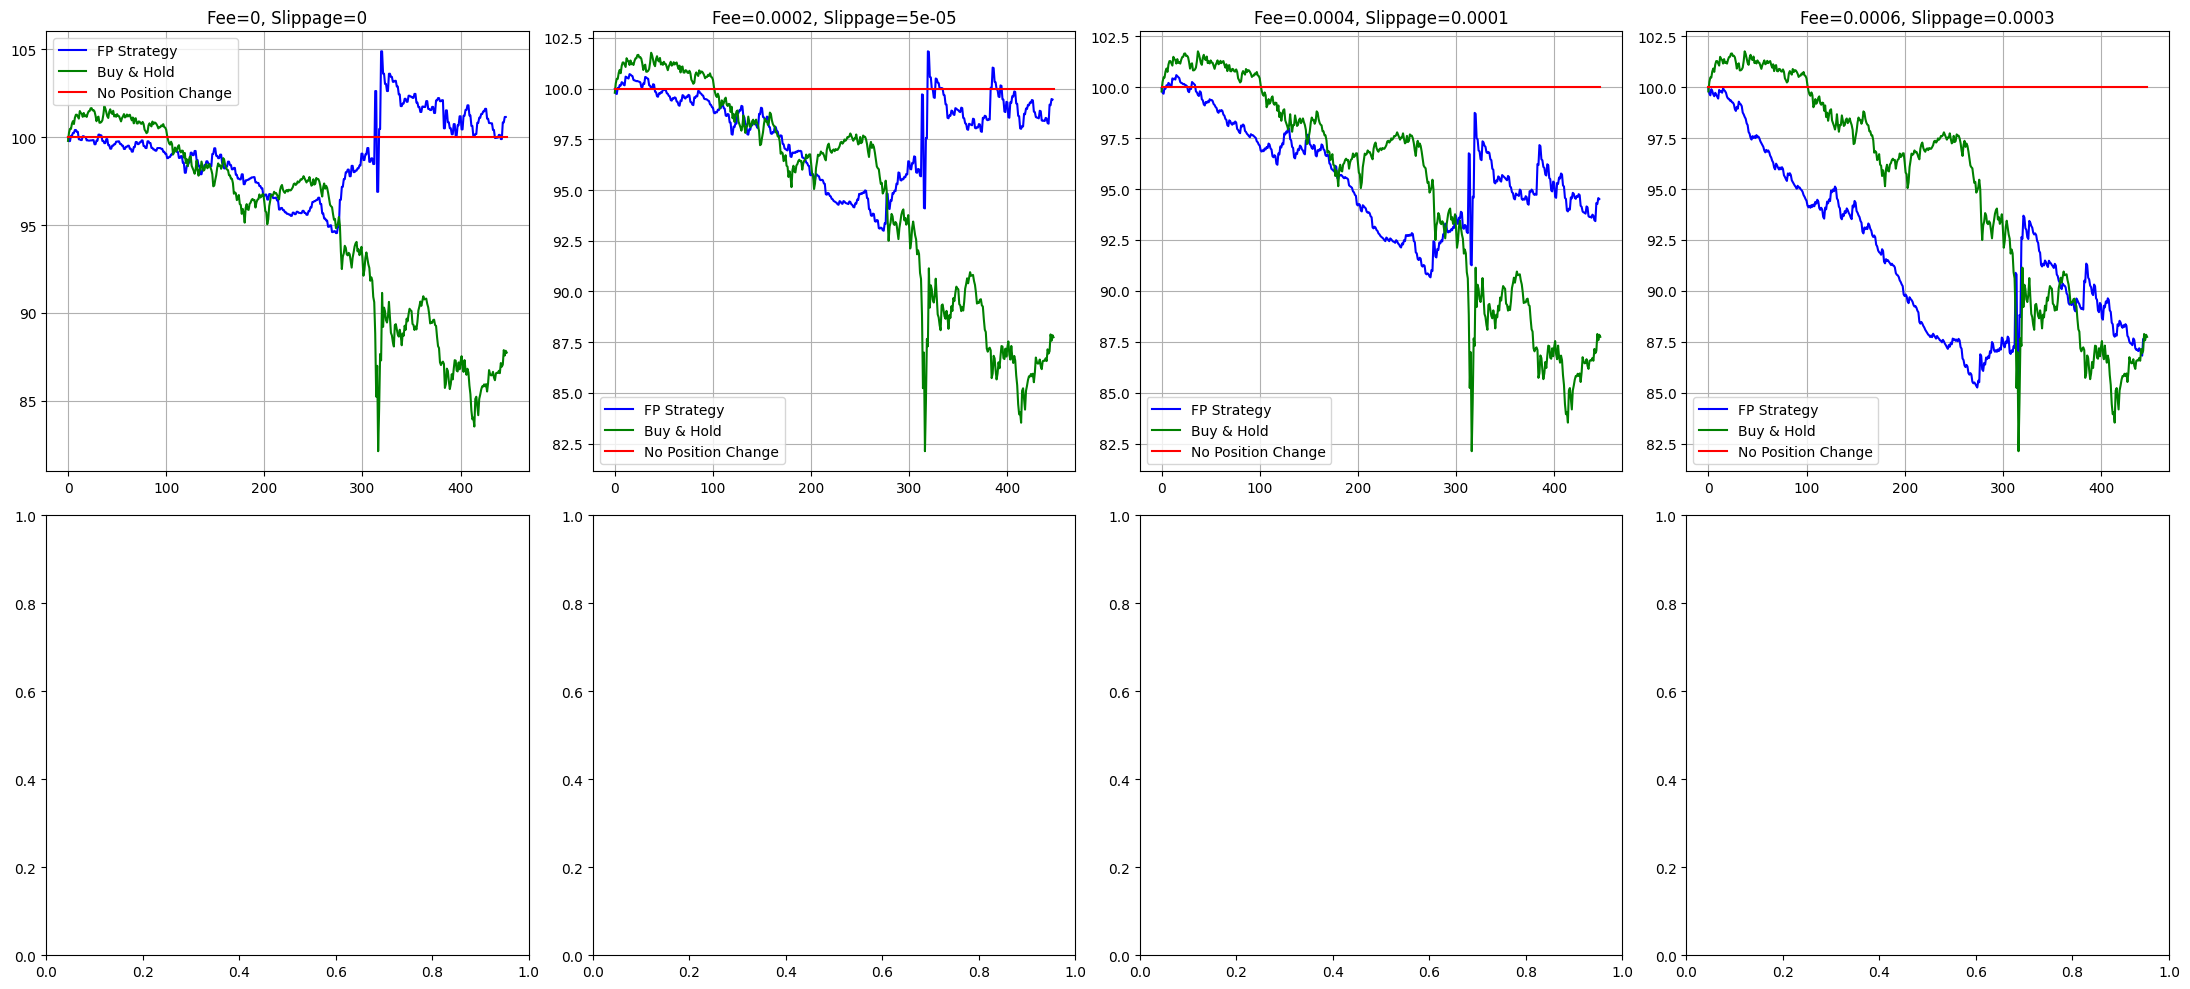


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           101.16           1.16           87.74                 -12.26    100.0             0.0
0.0002   0.00005            99.46          -0.54           87.74                 -12.26    100.0             0.0
0.0004   0.00010            94.51          -5.49           87.74                 -12.26    100.0             0.0
0.0006   0.00030            87.76         -12.24           87.74                 -12.26    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

# Load and preprocess data
df = pd.read_csv("ETH_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.tanh(signal / threshold)
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    costs[~trade_mask] = 0
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = np.abs(first_position) * (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


In [ ]:
df = pd.read_csv("BTC_1sec.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()
df

/tmp/ipython-input-5-3420910582.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,bid_price_14,ask_price_14,obi,dobi,depth,queue_slope_bid,queue_slope_ask,net_queue_slope,depth_variance,abs_dobi
0,0,2021-04-07 11:32:42.122161+00:00,56035.995,0.0,0.000000,0.0,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,56035.995642,56035.995359,-0.262372,0.000000,7.950047e+05,-19727.020752,1515.210052,-21242.230804,54851.604231,0.000000
1,1,2021-04-07 11:32:43.122161+00:00,56035.995,0.0,0.000000,0.0,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,56035.995642,56035.995359,-0.262372,0.000000,7.950047e+05,-19727.020752,1515.210052,-21242.230804,54851.604231,0.000000
2,2,2021-04-07 11:32:44.122161+00:00,56035.995,0.0,0.000000,0.0,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,56035.995642,56035.995359,-0.262372,0.000000,7.950047e+05,-19727.020752,1515.210052,-21242.230804,54851.604231,0.000000
3,3,2021-04-07 11:32:45.122161+00:00,56035.995,0.0,0.000000,0.0,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,56035.995642,56035.995359,-0.262372,0.000000,7.950047e+05,-19727.020752,1515.210052,-21242.230804,54851.604231,0.000000
4,4,2021-04-07 11:32:46.122161+00:00,56035.995,0.0,0.000000,0.0,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,56035.995642,56035.995359,-0.262372,0.000000,7.950047e+05,-19727.020752,1515.210052,-21242.230804,54851.604231,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83309,83309,2021-04-08 10:41:15.114732+00:00,56687.825,0.0,980.417720,0.0,-8.820236e-08,-3.748600e-05,-0.000038,-0.000038,...,56687.825125,56687.825255,0.574471,-0.030246,1.003584e+06,248187.203125,-7229.871094,255417.074219,75438.643820,0.030246
83310,83310,2021-04-08 10:41:16.114732+00:00,56687.825,0.0,0.000000,0.0,-8.820236e-08,-3.748600e-05,-0.000038,-0.000039,...,56687.825125,56687.825248,0.533117,-0.041354,1.030651e+06,358170.024902,-7229.871094,365399.895996,72084.854619,0.041354
83311,83311,2021-04-08 10:41:17.114732+00:00,56687.825,0.0,0.000000,0.0,-8.820236e-08,-2.160958e-05,-0.000037,-0.000037,...,56687.825100,56687.825248,0.605677,0.072560,1.093475e+06,123102.000000,-5701.779297,128803.779297,65633.073641,0.072560
83312,83312,2021-04-08 10:41:18.114732+00:00,56687.825,0.0,0.000000,0.0,-8.820236e-08,-1.455339e-05,-0.000029,-0.000037,...,56687.825107,56687.825248,0.626250,0.020573,1.177688e+06,237428.187500,-5701.779297,243129.966797,82318.326271,0.020573
